# Train a deep SNN on the SHD Dataset

In [20]:
import os
import sys
sys.path.append("../../")

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import stork.datasets
from stork.datasets import HDF5Dataset, DatasetView

from stork.models import RecurrentSpikingModel
from stork.nodes import InputGroup, ReadoutGroup, LIFGroup
from stork.connections import Connection
from stork.generators import StandardGenerator
from stork.initializers import FluctuationDrivenCenteredNormalInitializer

## Load Dataset

***To locally run this notebook on your system, download the SHD dataset from: [https://zenkelab.org/datasets/](https://zenkelab.org/datasets/).***
*We need 'shd_train.h5' and 'shd_test.h5'. Move the downloaded files into a folder `data/datasets/hdspikes` in this repo, or change the `datadir` variable below. 

In [21]:
datadir = "./data/datasets/hdspikes"

Next, we specify the Dataset Parameters.

In [22]:
nb_inputs = 700
duration = 0.7
time_step = dt = 2e-3
nb_time_steps = int(duration / time_step)
time_scale = 1
unit_scale = 1
validation_split = 0.9

In [23]:
gen_kwargs = dict(
    nb_steps=nb_time_steps,
    time_scale=time_scale / time_step,
    unit_scale=unit_scale,
    nb_units=nb_inputs,
    preload=True,
    precompute_dense=False,
    unit_permutation=None
    )

In [24]:
train_dataset = HDF5Dataset(os.path.join(datadir, "shd_train.h5"), **gen_kwargs)

# Split into train and validation set
mother_dataset = train_dataset
elements = np.arange(len(mother_dataset))
np.random.shuffle(elements)
split = int(validation_split * len(mother_dataset))
valid_dataset = DatasetView(mother_dataset, elements[split:])
train_dataset = DatasetView(mother_dataset, elements[:split])

test_dataset = HDF5Dataset(os.path.join(datadir, "shd_test.h5"), **gen_kwargs)

## Set up the model

In [25]:
# Model Parameters
batch_size = 400
beta = 20
device = torch.device("cuda:1")
dtype = torch.float


nb_hidden_units = 1248
nb_hidden_layers = 1
nb_classes = 20

tau_mem = 20e-3
tau_syn = 10e-3
tau_readout = duration

lr = 5e-3
nb_epochs = 100

In [26]:
act_fn = stork.activations.SuperSpike
act_fn.beta = beta
neuron_group = LIFGroup

model = RecurrentSpikingModel(
    batch_size,
    nb_time_steps,
    nb_inputs,
    device,
    dtype)

Create regularizers

In [27]:
# Define regularizer parameters (set regularizer strenght to 0, if you don't want to use them)
lowerBoundL2Strength = 100
lowerBoundL2Threshold = 1e-3
upperBoundL2Strength = 0.1
upperBoundL2Threshold = 7       # Regularizes spikecount: 7 spikes ~ 10 Hz in 700ms simulation time

# Define regularizer list
regs = []

regLB = stork.regularizers.LowerBoundL2(lowerBoundL2Strength, threshold=lowerBoundL2Threshold, dims=False)
regs.append(regLB)
regUB = stork.regularizers.UpperBoundL2(upperBoundL2Strength,threshold=upperBoundL2Threshold, dims=1)
regs.append(regUB)

We initialize the network in the Flucutation-Driven regime, with a target membrane potential standard deviation $\sigma_U=1.0$

In [28]:
sigma_u = 1.0
nu = 15.8

initializer = FluctuationDrivenCenteredNormalInitializer(
    sigma_u = sigma_u, 
    nu=nu, 
    timestep = dt
    )

Add input neuron group

In [29]:
input_group = model.add_group(InputGroup(nb_inputs))

Now we want to add multiple hidden layers as well as regularizers for them

In [30]:
upstream_group = input_group
for l in range(nb_hidden_layers):
    hidden_neurons = model.add_group(LIFGroup(
        nb_hidden_units,
        tau_mem=tau_mem,
        tau_syn=tau_syn,
        activation=act_fn))

    hidden_neurons.regularizers.extend(regs)
    con = model.add_connection(Connection(upstream_group, hidden_neurons))
    con.init_parameters(initializer=initializer)

    upstream_group = hidden_neurons

In [31]:
readout_group = model.add_group(ReadoutGroup(
    nb_classes,
    tau_mem=tau_readout,
    tau_syn=tau_syn,
    initial_state=-1e-2))

con_ro = model.add_connection(Connection(upstream_group, readout_group))
con_ro.init_parameters(initializer=initializer)

Add monitors for spikes and membrane potential

In [32]:
for i in range(nb_hidden_layers):
    model.add_monitor(stork.monitors.SpikeCountMonitor(model.groups[1 + i]))

for i in range(nb_hidden_layers):
    model.add_monitor(stork.monitors.StateMonitor(model.groups[1 + i], "out"))

Choose loss function (We chose a maximum over time crossentropy loss, where the class is chosen according to the readout neuron that has the highest membrane potential over the simulation time)

In [33]:
loss_stack = stork.loss_stacks.MaxOverTimeCrossEntropy()

We select the SMORMS3 optimizer

In [34]:
opt = stork.optimizers.SMORMS3
generator = StandardGenerator(nb_workers=2)

In [35]:
model.configure(input=input_group,
                output=readout_group,
                loss_stack=loss_stack,
                generator=generator,
                optimizer=opt,
                optimizer_kwargs=dict(lr=lr),
                time_step=dt)

Before we train the model, we monitor the spikes (ca. 20s)

In [36]:
# Monitors spike counts before training
res = model.monitor(test_dataset)
total_spikes = [torch.sum(res[i]).item() for i in range(nb_hidden_layers)]

results = {}
res = model.monitor(test_dataset)
total_spikes_per_layer = [torch.sum(res[i]).item()for i in range(nb_hidden_layers)]
results["avg_layer_freq_init"] = [nb/len(test_dataset)/duration/nb_hidden_units for nb in total_spikes_per_layer]

print(results)

{'avg_layer_freq_init': [16.460412379140294]}


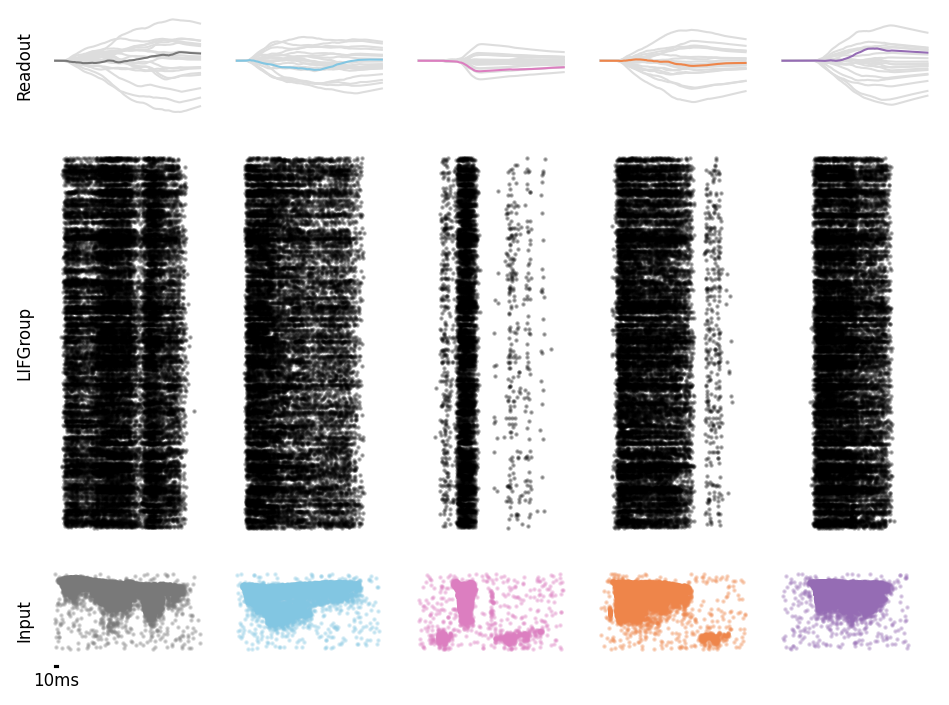

In [37]:
plt.figure(dpi=150)
stork.plotting.plot_activity_snapshot(
    model,
    data=test_dataset,
    nb_samples=5,
    point_alpha=0.3)

## Train

It takes around 50 min using a powerful GPU

In [38]:
history = model.fit_validate(
    train_dataset,
    valid_dataset,
    nb_epochs=nb_epochs,
    verbose=True)

results["train_loss"] = history["loss"].tolist()
results["train_acc"] = history["acc"].tolist()
results["valid_loss"] = history["val_loss"].tolist()
results["valid_acc"] = history["val_acc"].tolist()

00  loss=6.07 reg_loss=1.05 acc=0.0708 -- val_loss=2.89 val_reg_loss=0.147 val_acc=0.114 t_iter=11.58
01  loss=2.86 reg_loss=0.0833 acc=0.114 -- val_loss=2.77 val_reg_loss=0.026 val_acc=0.145 t_iter=11.53
02  loss=2.73 reg_loss=0.0246 acc=0.167 -- val_loss=2.67 val_reg_loss=0.0118 val_acc=0.187 t_iter=11.30
03  loss=2.6 reg_loss=0.0147 acc=0.212 -- val_loss=2.56 val_reg_loss=0.00904 val_acc=0.201 t_iter=11.60
04  loss=2.53 reg_loss=0.0116 acc=0.246 -- val_loss=2.54 val_reg_loss=0.00793 val_acc=0.21 t_iter=11.20
05  loss=2.44 reg_loss=0.0131 acc=0.271 -- val_loss=2.43 val_reg_loss=0.0102 val_acc=0.263 t_iter=12.32
06  loss=2.32 reg_loss=0.0124 acc=0.318 -- val_loss=2.34 val_reg_loss=0.00734 val_acc=0.283 t_iter=11.63
07  loss=2.26 reg_loss=0.0125 acc=0.348 -- val_loss=2.33 val_reg_loss=0.0101 val_acc=0.295 t_iter=13.10
08  loss=2.16 reg_loss=0.0126 acc=0.373 -- val_loss=2.29 val_reg_loss=0.00961 val_acc=0.322 t_iter=12.00
09  loss=2.01 reg_loss=0.0121 acc=0.424 -- val_loss=2.14 val_reg_

Monitor the model again after training

In [39]:
res = model.monitor(test_dataset)
total_spikes_per_layer = [torch.sum(res[i]).item()for i in range(nb_hidden_layers)]
results["avg_layer_freq"] = [nb/len(test_dataset)/duration/nb_hidden_units for nb in total_spikes_per_layer]


## Test

In [40]:
scores = model.evaluate(test_dataset).tolist()
results["test_loss"], _, results["test_acc"] = scores

Test loss:  1.877388020356496
Test acc.:  0.5866540404040403


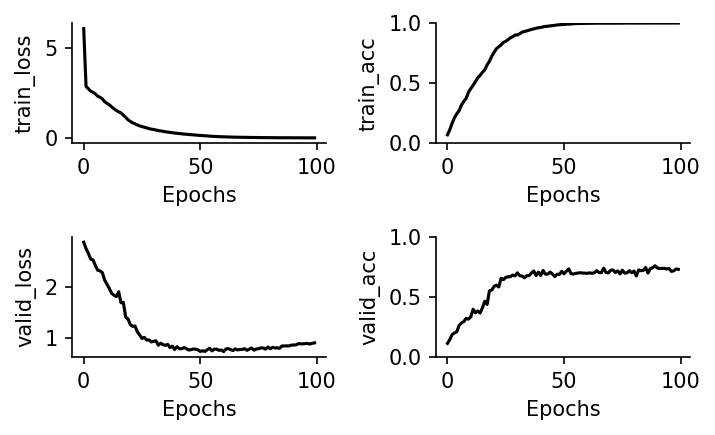

In [41]:
fig, ax = plt.subplots(2,2, figsize=(5,3), dpi=150)

for i, n in enumerate(["train_loss", "train_acc", "valid_loss", "valid_acc"]):
    
    if i < 2:
        a = ax[0][i]
    else:
        a = ax[1][i-2]

    a.plot(results[n], color="black")
    a.set_xlabel("Epochs")
    a.set_ylabel(n)

ax[0, 1].set_ylim(0, 1)
ax[1, 1].set_ylim(0, 1)

sns.despine()
plt.tight_layout()

print("Test loss: ", results["test_loss"])
print("Test acc.: ", results["test_acc"])

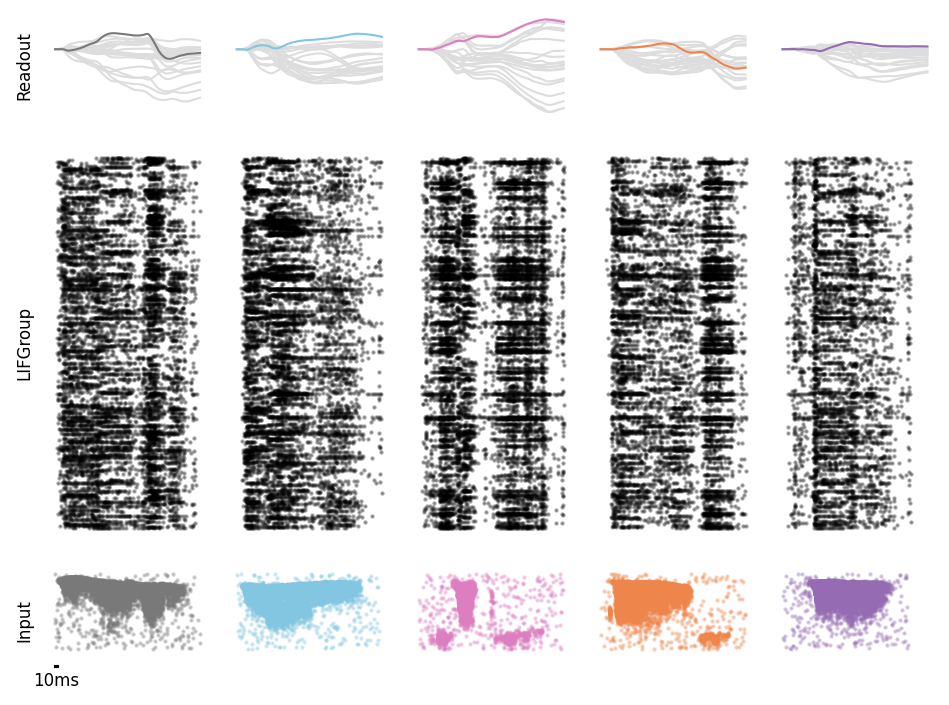

In [43]:
plt.figure(dpi=150)
stork.plotting.plot_activity_snapshot(
    model,
    data=test_dataset,
    nb_samples=5,
    point_alpha=0.3)